# Transfer Learning with ImageNet Pre-trained Models

## Import libraries

In [1]:
import numpy as np 
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import glob
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import random

## Look at some of the images and their class labels

In [2]:
# Image directories

file_dict = {'architecture': '/kaggle/input/architecture-dataset/arcDataset',
            'pneumonia': '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
            'german_traffic': '/kaggle/input/gtsrb-german-traffic-sign/Train',
            'intel': '/kaggle/input/intel-image-classification/seg_train/seg_train',
            'food': '/kaggle/input/food11-image-dataset/training',
            'imagenet': '/kaggle/input/imagenetmini-1000/imagenet-mini/train'}

In [3]:
# Create a dictionary that numerates classes within each dataset

def make_class_dict_for_plotting(img_folder):
    
    class_dict = {}
    i = 0
    
    for folder in glob.glob(img_folder + '/*'):
        
        if(len(glob.glob(folder + '/*')) > 0):
            class_str = folder.split('/')[-1]
            class_dict[i] = class_str
            i = i + 1
        
    return class_dict

'NORMAL'

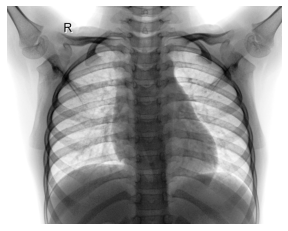

In [5]:
# Generate a random image and its class label from TASK
# (Used for writing report, making presentation)

TASK = 'pneumonia'

img_path = file_dict[TASK]
img_classes = make_class_dict_for_plotting(img_path)

# generate a random integer between 0 and # images
class_int = random.randrange(len(img_classes))

# get that list
class_folder = img_path + '/' + img_classes[class_int]

# plot a random picture
pictures = glob.glob(class_folder + '*/*.*')
pic_int = random.randrange(len(pictures))
plt.imshow(plt.imread(pictures[pic_int]), cmap = "Greys")
plt.axis('off')
img_classes[class_int]

## Seed everything for reproducibility 

In [ ]:
import random

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

## Set the device to GPU if it's available

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Find the color images that don't have 3 channels, or the black and white images that have more than one channel, so we can remove them from the datasets

In [ ]:
'''
total_images = 0

for _, folder in file_dict.items():
    total_images += len(glob.glob(folder + '/*/*.*'))
    
def get_problem_images():
    
    problem_images = []
    i = 0
    for task, folder in file_dict.items():
        
        if(task == 'pneumonia'):
            for image in glob.glob(folder + '/*/*.*'):
                i += 1
                try:
                    a = plt.imread(image)
                except:
                    problem_images.append(image)
                try: 
                    if(len(a[0][0]) >= 0):
                        problem_images.append(image)
                except:
                    k = 1
                    # do nothing
                print(str(i) + '/' + str(total_images))
        else:
            for image in glob.glob(folder + '/*/*.*'):
                i += 1
                try:
                    a = plt.imread(image)
                except:
                    problem_images.append(image)
                try: 
                    if(len(a[0][0]) != 3):
                        problem_images.append(image)
                except:
                    problem_images.append(image)

                print(str(i) + '/' + str(total_images))
    return problem_images

problem_images = get_problem_images()
'''

## After the first time, the problem images are loaded

In [ ]:
problem_images = pd.read_csv('/kaggle/input/finalproblemimages/final_problem_images.csv')
problem_images = list(problem_images['Problem Images'])

## Additional helper functions

In [ ]:
# Assigns an integer to each class in an image folder
# that can be used as a label

def make_class_dict(img_folder):
    
    class_dict = {}
    i = 0
    
    for folder in glob.glob(img_folder + '/*'):
        
        if(len(glob.glob(folder + '/*')) > 0):
            class_str = folder.split('/')[-1]
            class_dict[class_str] = i
            i = i + 1
        
    return class_dict

## Torch datasets

In [ ]:
# Torch dataset for testing

class test_dataset(torch.utils.data.Dataset):
    
    def __init__(self, img_folder, class_size, file_type, input_size, task):
        
        self.img_folder = img_folder
        
        filenames = []
        
        class_size = class_size
        
        folder_list = glob.glob(self.img_folder + '/*')
        
        for folder in folder_list:
            filenames.extend([file for file in glob.glob(folder + '/*.' + file_type) if not file in problem_images][:test_size_dict[task]])
          
        self.filenames = filenames
        self.class_dict = make_class_dict(img_folder)
        
        # Note that we don't use data augmentation
        if(task == 'pneumonia'):
            self.transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
        else: 
            self.transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        self.len = len(self.filenames)
        
        # An item is the image and its label
    def __getitem__(self, index):
        
        # torch.transform wants a PIL image object
        image = Image.open(self.filenames[index])

        label = self.class_dict[self.filenames[index].split(self.img_folder + '/')[1].split('/')[0]]
        return self.transform(image), label
    
        # Length is already defined
    def __len__(self):
        return self.len

In [ ]:
# Torch dataset for training and validation

class train_dataset(torch.utils.data.Dataset):
    
    def __init__(self, img_folder, class_size, file_type, input_size, task):
        
        self.img_folder = img_folder
        
        filenames = []
        
        class_size = class_size
        
        folder_list = glob.glob(self.img_folder + '/*')
        
        for folder in folder_list:
            filenames.extend([file for file in glob.glob(folder + '/*.' + file_type) if not file in problem_images][test_size_dict[task]:class_size + test_size_dict[task]])
            
        self.filenames = filenames
        self.class_dict = make_class_dict(img_folder)
        
        # Note that we don't use data augmentation
        if(task == 'pneumonia'):
            self.transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
        else: 
            self.transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        self.len = len(self.filenames)
        
        # An item is the image and its label
    def __getitem__(self, index):
        
        # torch.transform wants a PIL image object
        image = Image.open(self.filenames[index])

        label = self.class_dict[self.filenames[index].split(self.img_folder + '/')[1].split('/')[0]]
        return self.transform(image), label
    
        # Length is already defined
    def __len__(self):
        return self.len

In [ ]:
# returns data loaders in the form train, val, test

def make_test_loader(dataset):
    
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return test_loader

In [ ]:
# returns data loaders in the form train, val, test

def make_train_val_loaders(dataset, train_size):
    
    train_len = int(train_size*dataset.len)
    val_len = dataset.len - train_len
    
    # Gets the training dataset and the validation/test dataset
    train, val = torch.utils.data.random_split(dataset, lengths = [train_len, val_len])
    
    # Make dataloaders
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
    
    return [train_loader, val_loader]

In [ ]:
# Train the model

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    k = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # If there was only one image in the batch, skip it
                # Otherwise this causes an error in the batch norm layers
                if(inputs.size()[0] <= 1):
                    continue

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Get model outputs and calculate loss
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                '''
                print(f'batch {k}')
                k = k + 1
                print()
                if(k > 500):
                    break
                '''
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc.cpu().numpy())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, best_acc, time_elapsed

In [ ]:
# Test the model

def test_model(model, dataloader):

    running_loss = 0.0
    running_corrects = 0
        
    for inputs, labels in dataloader:
        
        inputs.to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            
            # Get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)

    print('Test Acc: {:4f}'.format(acc))
    return acc

In [ ]:
# Initialize model

def initialize_model(model_name, num_classes, feature_extract, use_pretrained, task):

    model_ft = None
    input_size = 0

    if model_name == "resnet":

        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
        if(task == 'pneumonia'):
            model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    elif model_name == "alexnet":

        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
        if(task == 'pneumonia'):
            model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

    elif model_name == "inception":

        #print(f'init weights {init_weights}')
        model_ft = models.inception_v3(pretrained=use_pretrained, transform_input = False, init_weights = False)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

        if(task == 'pneumonia'):
            model_ft.Conv2d_1a_3x3.conv = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, bias = False)
        
    return model_ft, input_size

In [ ]:
# Whether weights should be updated or not

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Preamble

In [ ]:
# Holds the number of classes for each task
nclass_dict = {}

for key, file in file_dict.items():
    nclass_dict[key] = len([x for x in glob.glob(file + '/*') if len(glob.glob(x + '/*')) > 0])

In [ ]:
# Gets the minimum number of images within any class

def min_class_imgs(task):
    
    min_imgs = 10000000
    
    img_folder = file_dict[task]
    
    for folder in glob.glob(img_folder + '/*'):
        num_imgs = len(glob.glob(folder + '/*'))
        if(num_imgs > 0):
            if(num_imgs < min_imgs):
                min_imgs = num_imgs
    
    return min_imgs                   

In [ ]:
# Gets the maximum number of images in any class

def max_class_imgs(task):
    
    max_imgs = 0
    
    img_folder = file_dict[task]
    
    for folder in glob.glob(img_folder + '/*'):
        num_imgs = len(glob.glob(folder + '/*'))
        if(num_imgs > 0):
            if(num_imgs > max_imgs):
                max_imgs = num_imgs
    
    return max_imgs 

In [ ]:
tasks = ['architecture',
            'pneumonia',
            'food',
            'german_traffic',
            'intel']

In [ ]:
# Within each task, set the test size to be 20% of the minimum number of images in any single class

min_imgs_dict = {}
test_size_dict = {}
for task in tasks:
    min_imgs = min_class_imgs(task)
    min_imgs_dict[task] = min_imgs
    test_size_dict[task] = int(0.2*min_imgs)

In [ ]:
# Task is either architecture, pneumonia, food, german traffic, or intel
# Returns the training, validation, and test data loaders

def get_image_data(task, class_size, train_size, input_size):
    
    img_folder = file_dict[task]
    file_type = glob.glob(img_folder + '*/*/*')[0].split('.')[-1]
    
    train_val_set = train_dataset(img_folder, class_size, file_type, input_size, task)
    test_set = test_dataset(img_folder, class_size, file_type, input_size, task)
    
    train, val = make_train_val_loaders(train_val_set, train_size)
    test = make_test_loader(test_set)
    #train, val, test = make_data_loaders(dataset, train_size, val_size)
    
    return [train, val, test]

In [ ]:
# Hyperparameters

train_size = 0.8
val_size = 0.2
batch_size = 8
num_epochs = 10
criterion = nn.CrossEntropyLoss()

In [ ]:
# Lists to loop through 

class_sizes = [10, 100, 10000] # 10000 is all
model_names = ['inception', 'alexnet', 'resnet']
modes = ['feature_extracting', 'fine_tuning', 'from_scratch']

## Run experiments

In [ ]:
# Function to run experiments

def run_all_tests():
    
    all_results = pd.DataFrame(columns = ['Task', 'Model', 'Class size', 'Mode', 'best_val_acc', 'val_acc_history', 'test_acc', 'time_elapsed'])

    for task in tasks:
        for model in models:
            for class_size in class_sizes:
                for mode in modes:
                    print(' ')
                    print(f'Task: {task}')
                    print(f'Class size: {class_size}')
                    print(f'Model: {model_name}')
                    print(f'Mode: {mode}')

                    use_pretrained = mode != 'from_scratch'
                    is_inception = model_name == 'inception'

                    num_classes = nclass_dict[task]
                    data_dir = file_dict[task]

                    feature_extracting = mode == 'feature_extracting'
                    model, input_size = initialize_model(model_name, num_classes, feature_extracting, use_pretrained, task)
                    train, val, test = get_image_data(task, class_size, train_size, input_size)
                    model = model.to(device)
                   
                    params_to_update = model.parameters()
                    print("Params to learn:")
                    if feature_extracting:
                        params_to_update = []
                        for name,param in model.named_parameters():
                            if param.requires_grad == True:
                                params_to_update.append(param)
                                print("\t",name)
                    else:
                        for name,param in model.named_parameters():
                            if param.requires_grad == True:
                                print("\t",name)

                    # Observe that all parameters are being optimized
                    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

                    dataloaders = {}
                    dataloaders['train'] = train
                    dataloaders['val'] = val

                    trained_model, val_acc_history, best_val_acc, time_elapsed = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs = num_epochs, is_inception = is_inception)

                    trained_model.eval()
                    test_acc = test_model(trained_model, test)

                    all_results.loc[len(all_results.index)] = [task, model_name, class_size, mode, best_val_acc.cpu().numpy(), val_acc_history, test_acc.cpu().numpy(), time_elapsed]

    return all_results

In [ ]:
#results = run_all_tests()
#results.to_csv('results.csv')

In [ ]:
# Runs a single experiment

def run_a_test(task, model_name, class_size, mode):
    
    all_results = pd.DataFrame(columns = ['Task', 'Model', 'Class size', 'Mode', 'best_val_acc', 'val_acc_history', 'test_acc', 'time_elapsed'])

    print(' ')
    print(f'Task: {task}')
    print(f'Class size: {class_size}')
    print(f'Model: {model_name}')
    print(f'Mode: {mode}')

    use_pretrained = mode != 'from_scratch'
    is_inception = model_name == 'inception'

    num_classes = nclass_dict[task]
    data_dir = file_dict[task]

    feature_extracting = mode == 'feature_extracting'
    model, input_size = initialize_model(model_name, num_classes, feature_extracting, use_pretrained, task)
    train, val, test = get_image_data(task, class_size, train_size, input_size)
    model = model.to(device)

    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extracting:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    dataloaders = {}
    dataloaders['train'] = train
    dataloaders['val'] = val

    trained_model, val_acc_history, best_val_acc, time_elapsed = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs = num_epochs, is_inception = is_inception)

    trained_model.eval()
    test_acc = test_model(trained_model, test)

    all_results.loc[len(all_results.index)] = [task, model_name, class_size, mode, best_val_acc.cpu().numpy(), val_acc_history, test_acc.cpu().numpy(), time_elapsed]

    return all_results

## Verify cross-valiation accuracy is saturated by 10 epochs

In [ ]:
# Run a single experiment, save results, and plot validation accuracy

task = 'food'
model_name = 'resnet'
class_size = 10000
mode = 'from_scratch'
num_epochs = 50

single_test_result = run_a_test(task, model_name, class_size, mode)
single_test_result.to_pickle(f'{task}_{model_name}_{class_size}_{mode}_{num_epochs}_epochs')

plt.plot(single_test_result.loc[0, 'val_acc_history'])